In [42]:
# %reset

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import OrdinalEncoder

import utils as ut
from config import FeatureNames


### Описание датасета
#### Поля:
- id: уникальный id сообщения
- text: сообщение из чата в боте знакомств
- date: дата отправки сообщения
- photo: объект Photo из telethon, из которого в случае необходимости можно получить фотографию
### Задача:
1. Отобрать сообщения с анкетами и лайком/дизлайком

In [44]:
df = pd.read_csv("../data/to_train.csv")
# df = pd.read_csv("../data/to_test.csv")
df.drop(columns='Unnamed: 0', inplace=True)

In [45]:
df

,message,class,date,photo
0,"даша, 19, 📍4 км – привет! на фотке я, честно!!...",👎,2023-06-17 22:10:49+00:00,"Photo(id=5449375684381231919, access_hash=5531..."
1,"Соня, 19, Санкт-Петербург – Может сходим куда-...",❤️,2023-06-17 22:10:47+00:00,"Photo(id=5258182105643467576, access_hash=8189..."
2,"Sofffi, 19, 📍3 км",❤️,2023-06-17 22:10:27+00:00,"Photo(id=5208485429903478534, access_hash=-426..."
3,"Даяна, 21, Санкт-Петербург – Переехали с подру...",👎,2023-06-17 22:10:25+00:00,NaN
4,"Лариса, 19, Санкт-Петербург – Достаточно разно...",👎,2023-06-17 22:10:22+00:00,"Photo(id=5197312802627372418, access_hash=8874..."
...,...,...,...,...
22211,"Alexandra, 24, 📍4 км – Inst: alexandrina_maxim...",❤️,2022-10-11 18:12:32+00:00,"Photo(id=5280716231382516372, access_hash=7701..."
22212,"Таня, 20, 📍1 км – Я ветеринар. Работаю бармено...",👎,2022-10-11 18:12:25+00:00,"Photo(id=5278776718640923270, access_hash=3370..."
22213,"амина, 20, 📍4 км – мне 17,учусь в педагогическ...",👎,2022-10-11 18:12:20+00:00,"Photo(id=5258383999171149807, access_hash=8810..."
22214,"Наташа 👩🏻‍🏫, 23, 📍3 км – Расскажите об интерес...",👎,2022-10-11 18:12:17+00:00,"Photo(id=5310235404168969759, access_hash=4477..."


### Заменим "сердечко" и "палец вниз" на 1 и 0 соответственно

In [46]:
oEnc = OrdinalEncoder(categories = [['👎', '❤️']])
df['class'] = oEnc.fit_transform(df['class'].values.reshape(-1, 1))

### Анализ соотношения лайков и дизлайков

11.74 % лайков из общего количества


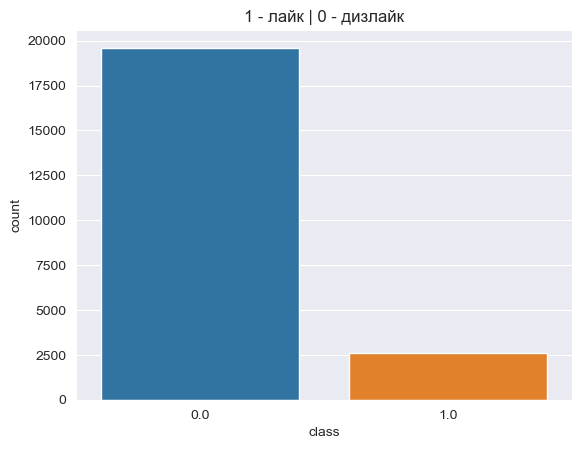

In [47]:
sns.countplot(df, x='class')
plt.title("1 - лайк | 0 - дизлайк")

like = df[df['class'] == 1]
dislike = df[df['class'] == 0]

print(round(len(like)/(len(dislike) + len(like))*100, 2), "% лайков из общего количества")

### Разделим сообщение на имя и возраст

In [48]:
df['name'] =  None
df['old'] =  None
pd.options.mode.chained_assignment = None  # default='warn'


In [49]:
df['name_old'] = None
df['name_old'] = df['message'].apply(ut.get_name_and_old)
df['name'] = df['name_old'].apply(ut.get_name)
df['old'] = df['name_old'].apply(ut.get_old)
df.drop(columns='name_old', inplace=True)
df.dropna(subset=['name', 'old'], inplace=True)
df.index = range(len(df))

### Разделим "уникальные имена" сначала на реальные имена, а после на "нравится|нормально|не нравится|не указано"

In [50]:
df['name'] = df['name'].apply(ut.split_names)

### Посмотрим топ 10 имён

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
# На всякий случай сохраним датасет
df_names = df.copy()

In [53]:
from collections import Counter
cnt = Counter(df_names['name'])
print()

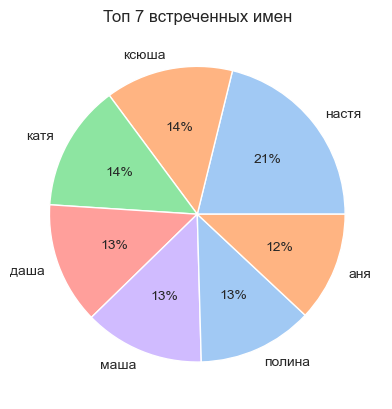

In [54]:
labels, data = zip(*cnt.most_common(8)[1:])
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[ 0:5 ]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Топ 7 встреченных имен')
# plt.show()
plt.savefig('../img/top7.png')

Статистика по лайкам:
[('настя', 146), ('ксюша', 134), ('полина', 107), ('катя', 107), ('аня', 104), ('маша', 103), ('даша', 94), ('лиза', 76), ('соня', 75), ('юля', 75)]

Статистика по дизлайкам:
[('настя', 1217), ('катя', 784), ('ксюша', 766), ('даша', 763), ('маша', 743), ('полина', 704), ('аня', 667), ('лиза', 562), ('алина', 555), ('соня', 483)]


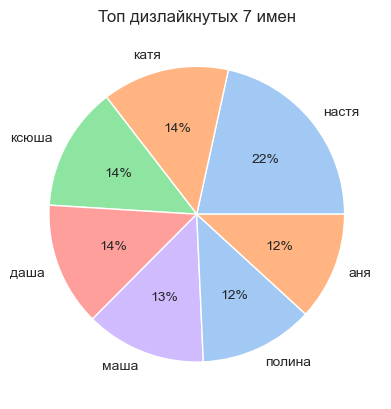

In [55]:
print("Статистика по лайкам:")
cnt = Counter(df_names[df_names['class'] == 1]['name'])
print(cnt.most_common(11)[1:])

labels, data = zip(*cnt.most_common(8)[1:])
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[ 0:5 ]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Топ  лайкнутых 7 имен')
# plt.show()
plt.savefig('../img/top7_like.png')


print()
print("Статистика по дизлайкам:")
cnt = Counter(df_names[df_names['class'] == 0]['name'])

labels, data = zip(*cnt.most_common(8)[1:])
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[ 0:5 ]

plt.cla()
#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title('Топ дизлайкнутых 7 имен')
# plt.show()
plt.savefig('../img/top7dislike.png')

print(cnt.most_common(11)[1:])

### Посмотрим какие имена я больше всего лайкал и дизлайкал

In [56]:
best_names = ['ксюша', 'вика', 'даша', 'аня', 'ирина', 'маша', 'кристина', 'алиса', 'лиза', 'ева', 'саша', 'юля', 'оля', 'диана', 'лера', 'женя', 'алёна',
              'анфиса', 'лариса', 'карина', 'полина', 'эвелина', 'таня']
cool_names = ['соня', 'арина',  'влада', 'надя',  'катя', 'вероника', 'вероника', 'анжелика', 'лена', 'наташа', 'стася', 'яна',
              'марина', 'ульяна', 'виолетта', 'гузель', 'света', 'альбина', 'варя', 'камилла', 'милена', 'диля', 'лиля', 'элеонора', 'алеcя', 'рита', 'вася',
              'зарина', 'валя', 'галя', 'нина', 'ангелина']
bad_names = ['даяна', 'алина', 'настя', 'снежа']
unknown = ['unknown']

In [57]:
df['name'].mask(df.name.isin(best_names), 'best_name', inplace=True)
df['name'].mask(df.name.isin(cool_names), 'norm_name', inplace=True)
df['name'].mask(df.name.isin(bad_names), 'bad_name', inplace=True)
df['name'].mask(df.name.isin(unknown), 'unknown_name', inplace=True)

[('best_name', 1177), ('unknown_name', 576), ('norm_name', 553), ('bad_name', 204)]


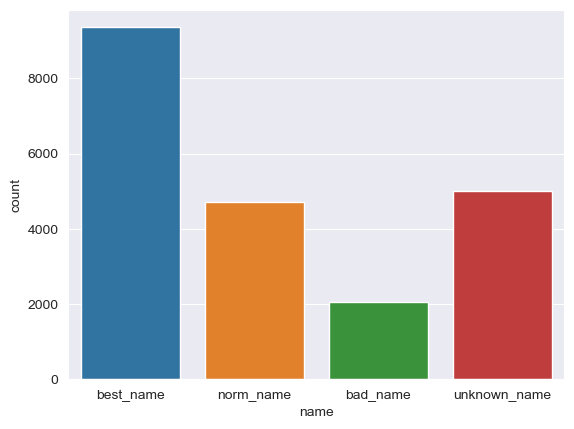

In [58]:
# 3 - best_name
# 2 - norm_name
# 1 - bad_name
# 0 - unknown_name
sns.countplot(df, x='name')

cnt = Counter(df[df['class'] == 1]['name'])
print(cnt.most_common(4))

oEnc = OrdinalEncoder(categories = [['unknown_name', 'bad_name', 'norm_name', 'best_name']])
df['name'] = oEnc.fit_transform(df['name'].values.reshape(-1, 1))

plt.savefig('../img/name_rating.png')

In [59]:
# Список для дальнейшего перевода в цифровой формат
cols = []

### Указано ли расстояние

In [60]:
# Проверка, указано ли расстояние
reg_exp = FeatureNames.distance_to
new_col_name = 'distance_to'
cols.append(new_col_name)
col_for_search = 'message'
value = 1
df = ut.check_phrase_existence(df, reg_exp, new_col_name, col_for_search, value)

### Указан ли рост

In [61]:
# Проверка, указан ли рост
reg_exp = FeatureNames.height
new_col_name = 'height'
cols.append(new_col_name)
col_for_search = 'message'
value = 1
df = ut.check_phrase_existence(df, reg_exp, new_col_name, col_for_search, value)

### Указано ли "Ищу отношения|ищу парня|..."

In [62]:
# Проверка, указано ли 'ищу парня итд...'
reg_exp = FeatureNames.romantic_relationships
new_col_name = 'romantic_relationships'
cols.append(new_col_name)
col_for_search = 'message'
value = 1
df = ut.check_phrase_existence(df, reg_exp, new_col_name, col_for_search, value)

### Сказано ли что-то про fwb/ons?

In [63]:
# Проверка, указано ли 'fwb|ons...'
reg_exp = FeatureNames.fwb_ons
new_col_name = 'fwb_ons'
cols.append(new_col_name)
col_for_search = 'message'
value = 1
df = ut.check_phrase_existence(df, reg_exp, new_col_name, col_for_search, value)

### Указано "Ищу общение|друга"

In [64]:
# Проверка, указано ли, что человек ничего не ищет
reg_exp = FeatureNames.not_looking_for
new_col_name = 'not_looking_for'
cols.append(new_col_name)
col_for_search = 'message'
value = -1
df = ut.check_phrase_existence(df, reg_exp, new_col_name, col_for_search, value)

### Указан ли инст?

In [65]:
# Проверка, указано ли, что человек ничего не ищет
reg_exp = FeatureNames.inst
new_col_name = 'inst'
cols.append(new_col_name)
col_for_search = 'message'
value = 1
df = ut.check_phrase_existence(df, reg_exp, new_col_name, col_for_search, value)

### Отпугивающее фразы

In [66]:
# Проверка, указаны ли отпугивающие фразы
reg_exp = FeatureNames.cringe_phrase
new_col_name = 'cringe_phrase'
cols.append(new_col_name)
col_for_search = 'message'
value = -1
df = ut.apply_sum_by_phrase(df, reg_exp, new_col_name, col_for_search, value)

### Схожие интересы

In [67]:
# Проверка, указаны ли совпадающие интересы
reg_exp = FeatureNames.similar_interests
new_col_name = 'similar_interests'
cols.append(new_col_name)
col_for_search = 'message'
value = 1
df = ut.apply_sum_by_phrase(df, reg_exp, new_col_name, col_for_search, value)

## Выделим текст сообщения (не включая имя, возраст и город)

In [68]:
df['text'] = ''
df['text'] = df['message'].apply(ut.split_message)

### Частые слова в лайках

In [69]:
# Очистка сообщения от ненужных символов
df['clean_text'] = df['text'].apply(ut.clean_text)
df['clean_text'] = df['clean_text'].fillna('')
df.drop(columns='text', inplace=True)

In [70]:
# df_like = df[df['class'] == 1]['clean_text']
#
# cnt = Counter()
# for text in df_like:
#     for word in text.split():
#         cnt[word] += 1 if len(word) > 2 else 0
#
# cnt.most_common(20)


### Пустая ли анкета

In [71]:
df['is_empty'] = 0
cols.append('is_empty')
df['is_empty'] = df['clean_text'].apply(ut.is_empty_string_analysis)


### Длина сообщения в анкете

In [72]:
df['message_len'] = 0
df['message_len'] = df['clean_text'].apply(len)

### Переведем всё из dtype = object в float:

In [73]:
for col in cols:
    ut.numeric_transform(df, col)
df['sum'] = df[cols].sum(axis=1)

### Датасет является несбалансированным -> исправим это

In [74]:
# Скопируем датасет для дальнейшего теста
df_full = df.copy()
df = ut.balance_the_dataset(df, 'class')


In [75]:
df.to_csv("../data/balanced_data.csv")
df_full.to_csv("../data/imbalanced_data.csv")

In [76]:
df

,message,class,date,photo,name,old,distance_to,height,romantic_relationships,fwb_ons,not_looking_for,inst,cringe_phrase,similar_interests,clean_text,is_empty,message_len,sum
0,"milky way, 19, Санкт-Петербург – 🌥️\r\n\r\n🌟я ...",0.0,2023-02-25 00:55:30+00:00,"Photo(id=5363968172346164751, access_hash=-223...",2.0,19.0,0,0,0,0,0,0,0,3,я не из спб решила попробовать поискать здесь...,0,391,3
1,"Лада, 23, Санкт-Петербург – Угараю по сталкачу...",0.0,2022-11-29 03:30:48+00:00,"Photo(id=5402585155312402698, access_hash=1123...",0.0,23.0,0,1,0,0,0,0,0,3,угараю по сталкачу фолычу и многим компьютерны...,0,340,4
2,"Анастасия, 19, СПб – сели выпивать два канниба...",1.0,2022-12-01 23:54:40+00:00,"Photo(id=5251211163268659050, access_hash=6676...",1.0,19.0,0,0,0,0,0,0,0,0,сели выпивать два каннибала закусил только оди...,0,75,0
3,Кому-то понравилась твоя анкета(и еще 1)\r\n\r...,1.0,2023-04-06 00:02:39+00:00,"Photo(id=5291833522299979640, access_hash=-618...",3.0,19.0,1,0,0,0,0,0,0,1,кому то понравилась твоя анкета и еще аня подг...,0,225,2
4,"Полинка, 19, Санкт-Петербург – 🫠 inst: pkoallii 🫠",1.0,2023-06-14 22:26:45+00:00,"Photo(id=5190517490055236428, access_hash=2815...",3.0,19.0,0,0,0,0,0,1,0,0,inst pkoallii,0,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,"Анастасия, 20, 📍3 км – Студентка меда\r\nЛюблю...",0.0,2023-03-04 03:56:28+00:00,"Photo(id=5341756753269868451, access_hash=-515...",1.0,20.0,1,0,0,0,0,0,0,2,студентка меда люблю читать фантастику и роман...,0,219,3
5016,"kate♏️, 19, Санкт-Петербург – безнадежный рома...",1.0,2022-12-17 18:26:18+00:00,"Photo(id=5465650853064064692, access_hash=6617...",2.0,19.0,0,0,0,0,0,0,0,1,безнадежный романтик выращенный поп культурой ...,0,341,1
5017,"Лизок, 20, Санкт-петербург – Ищу адекватное об...",1.0,2023-02-15 02:14:41+00:00,"Photo(id=5368640486878855419, access_hash=-407...",3.0,20.0,0,0,0,0,0,0,0,0,ищу адекватное общение,0,22,0
5018,"Арина, 21, 📍500м – Пока многие едут в Казахста...",0.0,2023-05-16 09:55:26+00:00,"Photo(id=5402442558103210540, access_hash=-230...",2.0,21.0,0,0,0,0,0,1,0,2,пока многие едут в казахстан я приехала в пите...,0,204,3


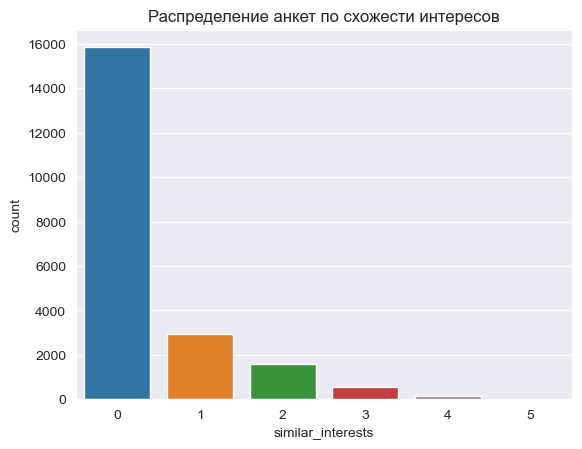

In [77]:
sns.countplot(x=df_full.similar_interests)
plt.title('Распределение анкет по схожести интересов')
plt.savefig('../img/similar_interests.png')

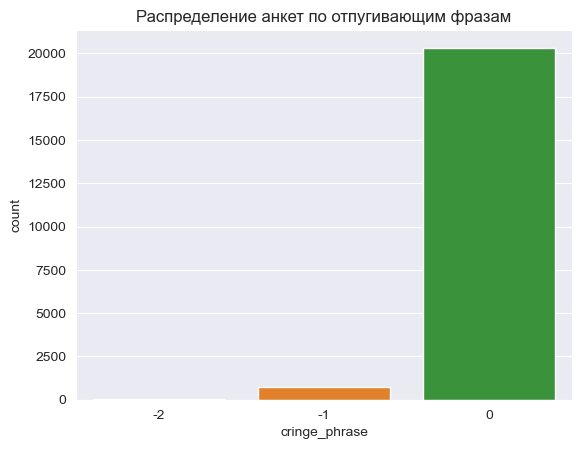

In [78]:
sns.countplot(x=df_full.cringe_phrase)
plt.title('Распределение анкет по отпугивающим фразам')
plt.savefig('../img/cringe_phrase.png')

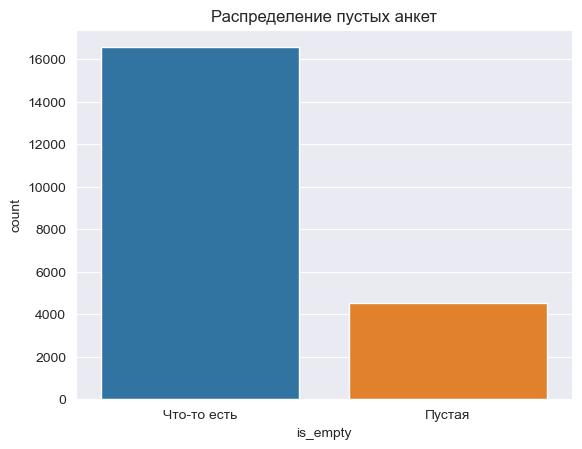

In [79]:
sns.countplot(x=df_full.is_empty.replace({0: 'Что-то есть', -1: 'Пустая'}))
plt.title('Распределение пустых анкет')
plt.savefig('../img/is_empty.png')

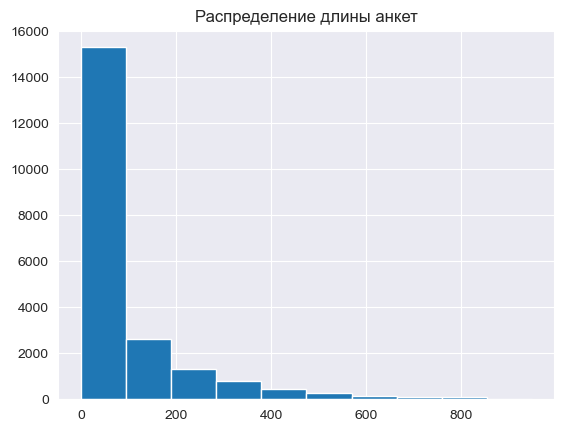

In [80]:
df_full.message_len.hist()
plt.title('Распределение длины анкет')
plt.savefig('../img/message_len.png')

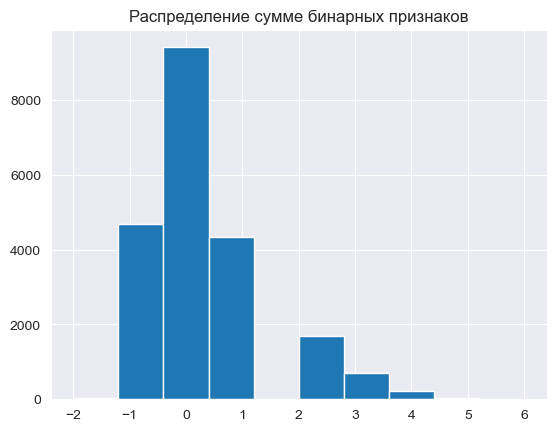

In [81]:
df_full['sum'].hist()
plt.title('Распределение сумме бинарных признаков')
plt.savefig('../img/sum.png')